In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. Sequential BayesianLearning

In [2]:
def sigmoid(a):
    # σ(a) = 1 / (1 + exp(−a))
    return 1 / (1 + np.exp(-a))

def gaussian_pdf(x, mean, sd):
    y = 1 / (2 * np.pi) * 1 / np.sqrt(np.linalg.det(sd)) * np.exp( -0.5 * ((x - mean).T.dot(np.linalg.inv(sd))).dot((x - mean)))
    return y
class RegressionModel:
    def __init__(self, M=3, s=0.6): 
        self.M = M
        self.s = s
    
    def basis_function(self, x):
        # M: number of parameter
        # μj: govern the locations of the basis functions in input space
        # s: governs their spatial scale.
        M, s = self.M, self.s
        new_x = np.empty([len(x), 0])

        for j in range(0, M):
            mu = 2*j/M
            new_x = np.concatenate((new_x, sigmoid((x-mu)/s)), axis=1)
        return new_x
    
    def posterior_distrib(self, x, t, alpha=math.pow(10, -6), beta=1):
        M, s = self.M, self.s
        
        phi = self.basis_function(x)
        # Calculation variance first
        # S0 = alpha*I
        # Sn = S0^-1 + beta*phi.T.dot(phi)
        S0 = alpha*np.identity(M)
        Sn_inverse = S0 + beta*phi.T.dot(phi)
        Sn = np.linalg.inv(Sn_inverse)
        #mN = beta*Sn*phi.T*t
        mN = Sn.dot(beta*phi.T).dot(t)
        return mN.flatten(), Sn
    def multivariate_normal(self, mN, Sn):
        w = np.random.multivariate_normal(mN.reshape(self.M), Sn, size=5)

        return w
        
    def predict(self, x, mN, Sn):
        w = self.multivariate_normal(mN.reshape(self.M), Sn)
        
        return x.dot(w.T)
    
    def predict_distrib(self, x, mN, SN, beta=1):
        phi = self.basis_function(x)
        mean = phi.dot(mN)
        var = 1/beta + np.sum(phi.dot(SN).dot(phi.T), axis=1)
        std = np.sqrt(var)
        return mean.reshape(len(x)), std

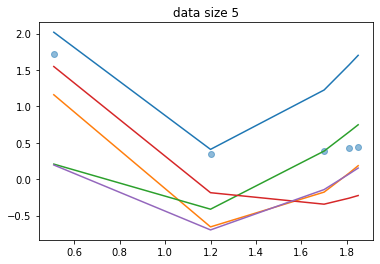

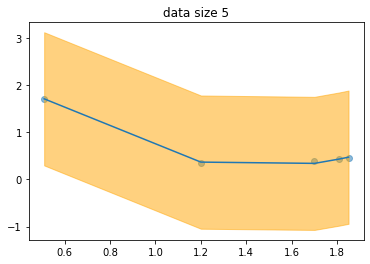

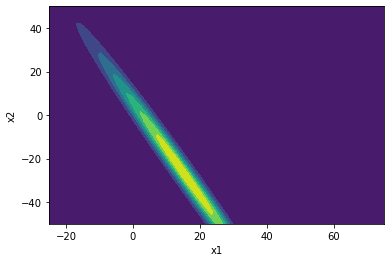

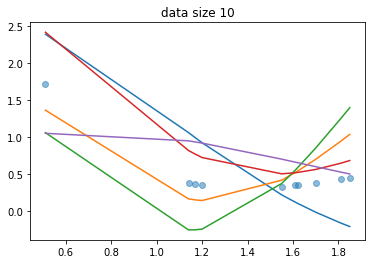

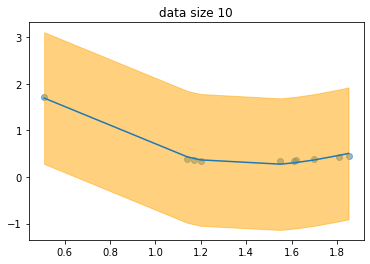

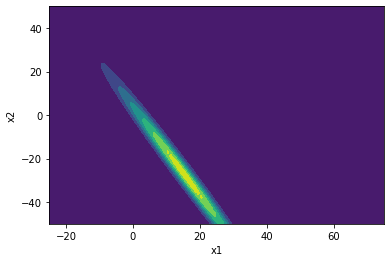

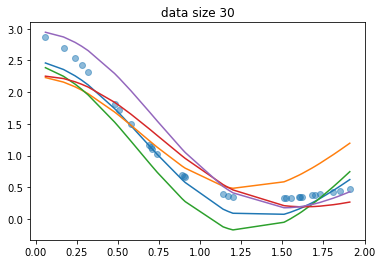

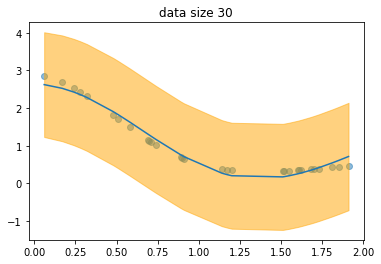

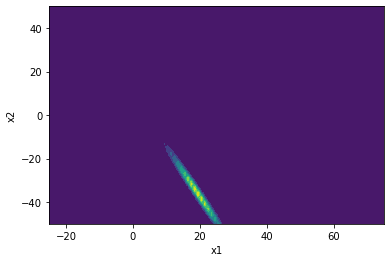

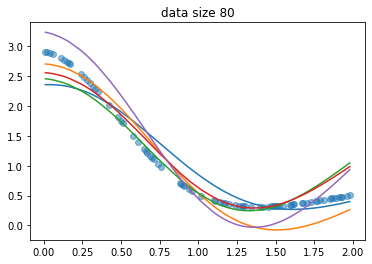

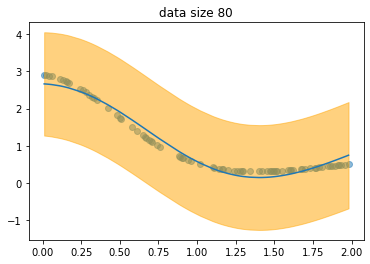

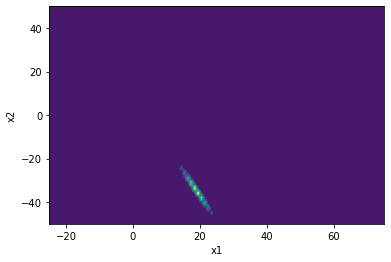

In [3]:

df = pd.read_csv('data.csv')
data = dict()
data['x'] = df['X'].values.reshape(100, 1)
data['t'] = df['T'].values.reshape(100, 1)

N_list = [5, 10, 30, 80]
# N_list = [10]
for N in N_list:
    RM = RegressionModel()
    x = data['x'][:N]
    t = data['t'][:N]
    # first figure
    plt.figure()
    mN, SN = RM.posterior_distrib(x, t)
    plt.scatter(x, t, alpha=0.5)
    x = np.array(sorted(x))
    y = RM.predict(RM.basis_function(x), mN, SN)
    plt.title('data size %d' % N)
    plt.plot(x, y, '-')

    # second figure
    plt.figure()
    mean, std = RM.predict_distrib(x, mN, SN)
    plt.scatter(data['x'][:N], t, alpha=0.5)
    plt.title('data size %d' % N)
    plt.fill_between(x.reshape(len(x)), (mean - std).reshape(len(y)), (mean + std).reshape(len(y)), color="orange",
                     alpha=0.5)
    plt.plot(x, mean, '-')

    # final
    plt.figure()
    w0, w1 = np.meshgrid(np.linspace(-25, 75, 100), np.linspace(-50, 50, 100))
    w_combined = np.array([w0, w1]).transpose(1, 2, 0)
    N_density = np.empty((100, 100))

    for f in range(N_density.shape[0]):
        for g in range(N_density.shape[1]):
            # select weight
            N_density[f, g] = gaussian_pdf(w_combined[f, g], mN[:2], SN[:2, :2])

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.contourf(w0[0], w1[:, 0], N_density)

    #plt.contourf(w0[0], w1[:, 0], N_density)
    plt.show()


# Logistic Regression

In [4]:
import zipfile, pygame
# using pygame to load file, if you don't have this module
# pls install by pip install pygame

def load_data(path='Fashion_MNIST',type='.zip'):
    print(path+type)
    archive = zipfile.ZipFile('Fashion_MNIST.zip', 'r')
    files = {name: archive.read(name) for name in archive.namelist() if name.endswith('.png')}
    png_h = 28; png_w = 28
    # load pics ti np array
    #64*5 = 320
    pics = np.zeros((320, png_h, png_w))
    labels = np.repeat(range(1, 6), 64)
    for i, k in enumerate(files):
        image = pygame.surfarray.array2d(pygame.image.load(k))
        pics[i] = image
    return pics, labels

def random_select(sum = 64, select=32, cat=5):
    idxs = []
    t_idxs = []
    for i in range(cat):
        idx = np.random.choice(np.arange(sum), select, replace=False) + i*sum
        idxs.extend(idx)
        # the rest is test
        t_idx = list(set(np.arange(i * sum, sum + i * sum)) - set(idx))
        t_idxs.extend(t_idx)

    return idxs, t_idxs
def soft_max(x):
    x -= np.max(x)
    return (np.exp(x).T / np.sum(np.exp(x), axis=1)).T

class logisticRegression():
    def __init__(self, w_size, cat):
        # init weights
        self.w = np.zeros([w_size, cat])
        self.lr = 1e-3
        self.tr_accuracy = [];self.tr_losses = []
        self.te_accuracy = [];self.te_losses = []

    def cross_entropy(self, t, p):
        return -np.sum(t * np.log(p))
    def plot_la(self, t1, t2 , tl='Learning curve: Gradient Descent w/o PCA'):
        a = np.arange(1000)
        #t1 = np.array(t1); t2 = np.array(t2)
        plt.title(tl)
        plt.plot(t1); plt.plot(t2)
        plt.legend(['train', 'test'], loc='upper right')
        #plt.xlabel(x_axis);plt.ylabel(y_axis)

        plt.show()

    def fit_byGD(self, X, y, Xt=None, yt=None, epochs=1000):
        for _ in range(0, epochs):
            # training section
            scores = np.dot(X, self.w)
            prob = soft_max(scores)
            m = X.shape[0]
            loss = (1/ m) * self.cross_entropy(y, prob)
            #pred = np.where(prob > 0.5, 1, 0)
            pred = change_y2(prob)

            # test section
            if len(Xt) != 0:
                scores_t = np.dot(Xt, self.w)
                prob_t = soft_max(scores_t)
                m = Xt.shape[0]
                loss_t = (1 / m) * self.cross_entropy(yt, prob_t)
                #pred_t = np.where(prob_t > 0.5, 1, 0)
                pred_t = change_y2(prob_t)
                # collect
                self.te_losses.append(loss_t)

                self.te_accuracy.append((pred_t == change_y(yt)).mean())

            # update weight
            grad = (-1 / m) * np.dot(X.T, (y - prob))
            self.w -= self.lr * grad
            # collect
            self.tr_losses.append(loss)
            self.tr_accuracy.append((pred == change_y(y)).mean())




    def fit_bySGD(self, X, y, Xt=None, yt=None, epochs=1000):
        m = len(y)
        mt = len(yt)
        for _ in range(0, epochs):
            SGD_loss = []
            SGD_loss_t = []
            for i in range(m):
                # train section
                rand_ind = np.random.randint(0, m)
                X_i = X[rand_ind, :].reshape(1, X.shape[1])
                y_i = y[rand_ind]
                scores = np.dot(X_i, self.w)
                prob = soft_max(scores)
                loss = (1 / m) * self.cross_entropy(y_i, prob)
                SGD_loss.append(loss)
                # test section
                if len(Xt) != 0:
                    rand_ind_t = np.random.randint(0, m)
                    X_i_t = Xt[rand_ind_t, :].reshape(1, Xt.shape[1])
                    y_i_t = y[rand_ind_t]
                    scores_t = np.dot(X_i_t, self.w)
                    prob_t = soft_max(scores_t)
                    loss_t = (1 / mt) * self.cross_entropy(y_i_t, prob_t)
                    SGD_loss_t.append(loss_t)
                # update weight
                grad = (-1 / m) * np.dot(X_i.T, (y_i - prob))
                self.w -= self.lr * grad
            self.tr_losses.append(sum(SGD_loss) / len(SGD_loss))
            self.te_losses.append(sum(SGD_loss_t) / len(SGD_loss_t))

            # find accuracy in other loop
            scores = np.dot(X, self.w)
            prob = soft_max(scores)
            m = X.shape[0]
            #pred = np.where(prob > 0.5, 1, 0)
            pred = change_y2(prob)
            self.tr_accuracy.append((pred == change_y(y)).mean())
            # test section
            scores_t = np.dot(Xt, self.w)
            prob_t = soft_max(scores_t)
            m = Xt.shape[0]
            #pred_t = np.where(prob_t > 0.5, 1, 0)
            pred_t = change_y2(prob_t)
            self.te_accuracy.append((pred_t == change_y(yt)).mean())

    def fit_byMSGD(self, X, y, Xt=None, yt=None,epochs=1000, batch_size=32):
        m = len(y)
        mt = len(yt)
        for _ in range(epochs):
            MSGD_loss = []
            MSGD_loss_t = []
            for i in range(0, m, batch_size):
                rand_ind = np.random.randint(0, m-32)
                X_i = X[rand_ind:rand_ind+batch_size]
                y_i = y[rand_ind:rand_ind+batch_size]
                scores = np.dot(X_i, self.w)
                prob = soft_max(scores)
                loss = (1 / m) * self.cross_entropy(y_i, prob)
                MSGD_loss.append(loss)
                # test section
                if len(Xt) != 0:
                    rand_ind_t = np.random.randint(0, m-32)
                    X_i_t = Xt[rand_ind_t:rand_ind_t + batch_size]
                    y_i_t = yt[rand_ind_t:rand_ind_t + batch_size]
                    scores_t = np.dot(X_i_t, self.w)
                    prob_t = soft_max(scores_t)
                    loss_t = (1 / mt) * self.cross_entropy(y_i_t, prob_t)
                    MSGD_loss_t.append(loss_t)
                # update weight
                grad = (-1 / m) * np.dot(X_i.T, (y_i - prob))
                self.w -= self.lr * grad

            self.tr_losses.append(sum(MSGD_loss) / len(MSGD_loss))
            self.te_losses.append(sum(MSGD_loss_t) / len(MSGD_loss_t))

            # find accuracy in other loop
            scores = np.dot(X, self.w)
            prob = soft_max(scores)
            #pred = np.where(prob > 0.5, 1, 0)
            pred = change_y2(prob)

            self.tr_accuracy.append((pred == change_y(y)).mean())
            # test section
            scores_t = np.dot(Xt, self.w)
            prob_t = soft_max(scores_t)
            pred_t = change_y2(prob_t)
            self.te_accuracy.append((pred_t == change_y(yt)).mean())

    def accuracy(self, X, y):
        scores = np.dot(X, self.w)
        prob = soft_max(scores)
        pred = np.where(prob > 0.5, 1, 0)
        return  (pred == y).all(axis=1).mean()

class newtonRaphson(logisticRegression):
    def __init__(self, w_size, cat):
        logisticRegression.__init__(self, w_size, cat)
        self.w_size = w_size
        self.cat = cat

    def phi(self, x):
        return x.reshape(len(x), 1)
    def compute_y(self, n, k, w, X):  # 公式裡的y
        s = np.float64(0.)
        ak = w[k].T.dot(self.phi(X[n]))
        # target classes
        for j in range(5):
            aj = w[j].T.dot(self.phi(X[n]))
            s += np.nan_to_num(np.exp(aj - ak))
        s = np.nan_to_num(s)
        return 1. / s
    def hessian(self, w, k, X):
        output = np.zeros((len(w[0]), len(w[0])))
        for n in range(len(X)):
            scale = self.compute_y(n, k, w, X) * (1 - self.compute_y(n, k, w, X))
            output += scale * (self.phi(X[n]).dot(self.phi(X[n]).T))
        return output

    def gradient(self, w, k, t, X):
        output = np.zeros((len(w[0]), 1))
        for n in range(len(X)):
            scale = self.compute_y(n, k, w, X) - t[:, k][n]  # Ynk - Tnk
            output += scale * self.phi(X[n])
        return output

    def error(self, w, t, X):
        s = np.float64(0.)
        for n in range(len(X)):
            for k in range(5):
                if t[:, k][n] != 0.:
                    s += np.nan_to_num(np.log(self.compute_y(n, k, w, X)))
        return -1 * s

    def fit_byNR(self, X, y, Xt, yt, epochs=10):
        self.w = np.zeros((self.cat, len(self.phi(X[0])), 1))
        m = X.shape[0]
        for e in range(epochs):
            new_x = self.w.reshape((self.w.shape[0], self.w.shape[1]))
            # train
            scores = np.dot(X, new_x.T)
            prob = soft_max(scores)
            loss = self.error(self.w, y, X).flatten()
            pred = change_y2(prob)
            self.tr_losses.append(loss)
            self.tr_accuracy.append((pred == change_y(y)).mean())
            # test
            scores_t = np.dot(Xt, new_x.T)
            prob_t = soft_max(scores_t)
            loss_t = self.error(self.w, yt, Xt).flatten()
            pred_t = change_y2(prob_t)
            self.te_losses.append(loss_t)
            self.te_accuracy.append((pred_t == change_y(yt)).mean())
            # update weight
            for k in range(5):
                # training
                self.w[k] = self.w[k] - np.linalg.pinv(
                    self.hessian(self.w, k, X)).dot(
                    self.gradient(self.w, k, y, X)
                )
    def predict(self, X):
        print(X.shape, self.w.shape)
        scores = np.dot(X, self.w.reshape((self.w.shape[0], self.w.shape[1])).T)
        prob = soft_max(scores)
        #preds = np.where(prob > 0.5, 1, 0)

        return change_y2(prob)

    def accuracy(self, X, y):
        scores = np.dot(X, self.w.reshape((self.w.shape[0], self.w.shape[1])).T)
        prob = soft_max(scores)
        pred = np.where(prob > 0.5, 1, 0)
        return (pred == y).all(axis=1).mean()

pygame 2.0.0 (SDL 2.0.12, python 3.7.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
def change_y(ys):
    res = []
    for y in ys:
        if y[0] == 1:
            res.append(1)
        elif y[1] == 1:
            res.append(2)
        elif y[2] == 1:
            res.append(3)
        elif y[3] == 1:
            res.append(4)
        elif y[4] == 1:
            res.append(5)
        '''else:
            res.append(1)'''
    return np.array(res)
def change_y2(y):
    ans = []
    for cat_ans in y:
        cat_ans = cat_ans.tolist()
        cat = cat_ans.index(max(cat_ans))
        ans.append(cat+1)
    return np.array(ans)

Fashion_MNIST.zip


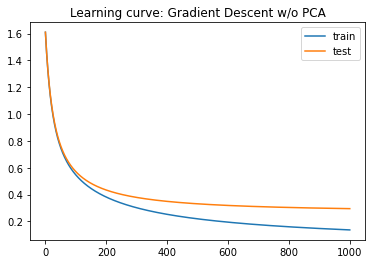

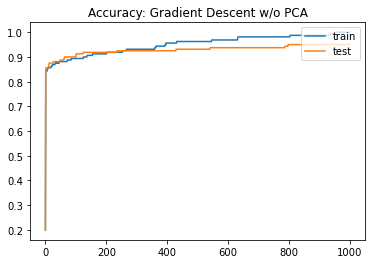

-------------------------------------
TYPE Gradient Desent
without PCA
Training accuracy:  0.95625
Test accuracy:  0.91875
-------------------------------------


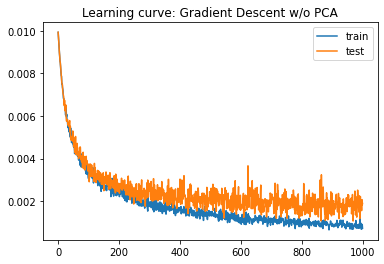

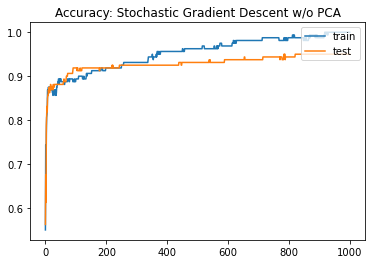

-------------------------------------
TYPE Stochastic Gradient Desent
without PCA
Training accuracy:  0.95625
Test accuracy:  0.925
--------------------------------------


In [6]:
pics, labels = load_data()
# normalize
pics_norm = pics / 255
feature = pics_norm.reshape(320, -1)
# normalize
feature = (feature - feature.mean())/feature.std()
target = pd.get_dummies(labels).values
idxs, t_idxs = random_select()
# split
X_train = feature[idxs]
y_train = target[idxs]
X_test = feature[t_idxs]
y_test = target[t_idxs]

model = logisticRegression(X_train.shape[1], 5)
model.fit_byGD(X_train, y_train, X_test, y_test,)
model.plot_la(model.tr_losses, model.te_losses)
model.plot_la(model.tr_accuracy, model.te_accuracy, tl='Accuracy: Gradient Descent w/o PCA')
print("-------------------------------------")
print('TYPE Gradient Desent\nwithout PCA')
print('Training accuracy: ', model.accuracy(X_train, y_train))
print('Test accuracy: ', model.accuracy(X_test, y_test))
print("-------------------------------------")

model = logisticRegression(X_train.shape[1], 5)
model.fit_bySGD(X_train, y_train, X_test, y_test,)
model.plot_la(model.tr_losses, model.te_losses)
model.plot_la(model.tr_accuracy, model.te_accuracy, tl='Accuracy: Stochastic Gradient Descent w/o PCA')
print("-------------------------------------")
print('TYPE Stochastic Gradient Desent\nwithout PCA')
print('Training accuracy: ', model.accuracy(X_train, y_train))
print('Test accuracy: ', model.accuracy(X_test, y_test))
print("--------------------------------------")



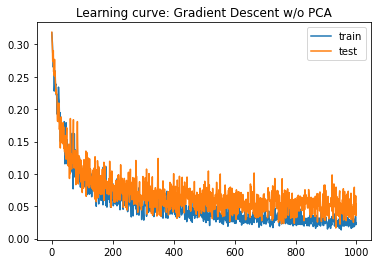

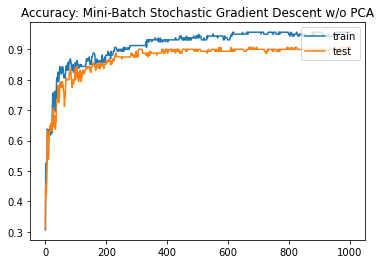

-------------------------------------
TYPE Mini-Batch Stochastic Gradient Desent
without PCA
Training accuracy:  0.93125
Test accuracy:  0.88125
-------------------------------------


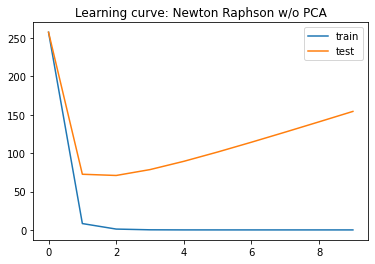

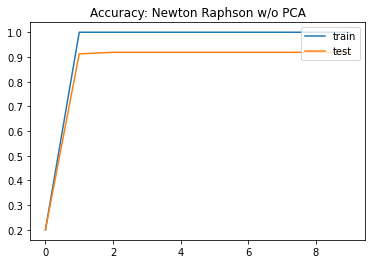

-------------------------------------
TYPE Newton Raphson
without PCA
Training accuracy:  1.0
Test accuracy:  0.90625
-------------------------------------


In [8]:
model = logisticRegression(X_train.shape[1], 5)
model.fit_byMSGD(X_train, y_train, X_test, y_test,)
model.plot_la(model.tr_losses, model.te_losses)
model.plot_la(model.tr_accuracy, model.te_accuracy, tl='Accuracy: Mini-Batch Stochastic Gradient Descent w/o PCA')
print("-------------------------------------")
print('TYPE Mini-Batch Stochastic Gradient Desent\nwithout PCA')
print('Training accuracy: ', model.accuracy(X_train, y_train))
print('Test accuracy: ', model.accuracy(X_test, y_test))
print("-------------------------------------")


model = newtonRaphson(X_train.shape[1], 5)
model.fit_byNR(X_train, y_train, X_test, y_test)
model.plot_la(model.tr_losses, model.te_losses, tl='Learning curve: Newton Raphson w/o PCA')
model.plot_la(model.tr_accuracy, model.te_accuracy, tl='Accuracy: Newton Raphson w/o PCA')
print("-------------------------------------")
print('TYPE Newton Raphson\nwithout PCA')
print('Training accuracy: ', model.accuracy(X_train, y_train))
print('Test accuracy: ', model.accuracy(X_test, y_test))
print("-------------------------------------")

# principal component analysis (PCA)

In [9]:
def PCA(features, n=2, n_eigVect=None, typ=1):
    mean = np.mean(features.T, axis=1)
    center = features - mean
    cov = np.cov(features, rowvar=0)
    eigenvalue, eigenvector = np.linalg.eig(np.mat(cov))
    sortEigValue = np.argsort(eigenvalue)  # sort eigenvalue
    topNvalue = sortEigValue[-1:-(n + 1):-1]  # select top n value
    if typ ==1 : # training data
        n_eigVect = eigenvector[:, topNvalue]  # select largest n eigenvector
    # recon = (C*n_eigVect.T) + M  # reconstruct to original data
    Trans = center * n_eigVect  # transform to low dim data (same as the return of sklearn fit_transform())
    # transform matrix to array
    Trans = np.asarray(Trans).real
    return Trans, n_eigVect, sortEigValue
    # print(Trans.shape)

n = 2


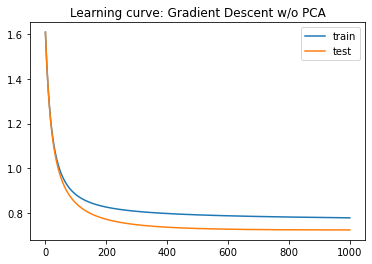

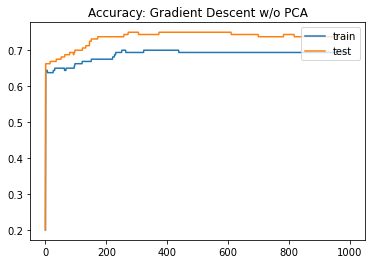

-------------------------------------
TYPE Gradient Desent
with PCA
Training accuracy:  0.55625
Test accuracy:  0.59375
-------------------------------------
n = 5


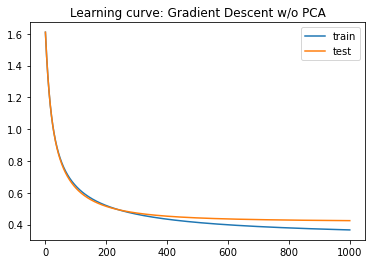

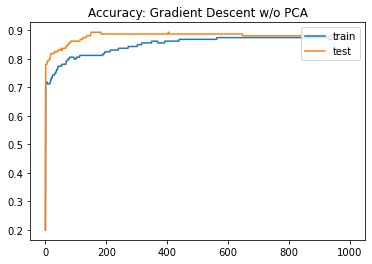

-------------------------------------
TYPE Gradient Desent
with PCA
Training accuracy:  0.8
Test accuracy:  0.8625
-------------------------------------
n = 10


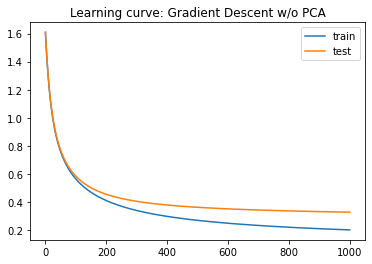

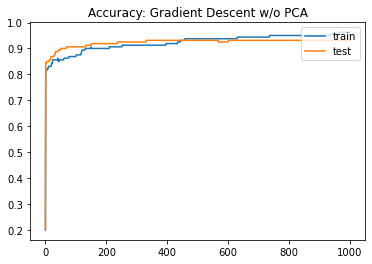

-------------------------------------
TYPE Gradient Desent
with PCA
Training accuracy:  0.925
Test accuracy:  0.9125
-------------------------------------


In [10]:

    
pca_n = [2, 5, 10]

for i in range(len(pca_n)):
    #init
    X_train = feature[idxs]
    y_train = target[idxs]
    X_test = feature[t_idxs]
    y_test = target[t_idxs]
    
    print('n =', pca_n[i])
    X_train, n_eigVect, _ = PCA(X_train, n=pca_n[i], typ=1)
    X_test, _, _ = PCA(X_test, n=pca_n[i], n_eigVect=n_eigVect, typ=2)
    
    model = logisticRegression(X_train.shape[1], 5)
    model.fit_byGD(X_train, y_train, X_test, y_test,)
    model.plot_la(model.tr_losses, model.te_losses)
    model.plot_la(model.tr_accuracy, model.te_accuracy, tl='Accuracy: Gradient Descent w/o PCA')
    print("-------------------------------------")
    print('TYPE Gradient Desent\nwith PCA')
    print('Training accuracy: ', model.accuracy(X_train, y_train))
    print('Test accuracy: ', model.accuracy(X_test, y_test))
    print("-------------------------------------")

(784,)


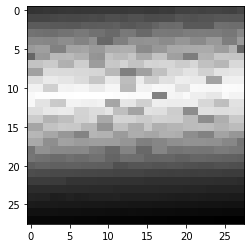

In [11]:
X_train = feature[idxs]
y_train = target[idxs]
X_test = feature[t_idxs]
y_test = target[t_idxs]
# 2.b show top d eigenvalues
X_train, n_eigVect, sortEigValue = PCA(X_train, n=10, typ=1)
print(sortEigValue.shape)
plt.imshow(sortEigValue.reshape(28, 28), cmap='gray')

(784,)


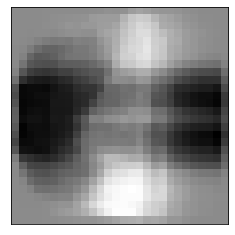

In [12]:
X_train = feature[idxs]
from sklearn.decomposition import PCA
pca = PCA(10)
pca5 = pca.fit(X_train)  # pca5.components_ 為(5, 92)應該是eigenvector
print(pca5.components_[0].shape)

# sklearn pca result
plt.imshow(pca5.components_[0].reshape(28, 28), cmap='gray')
plt.xticks(())
plt.yticks(())
plt.show()

In [14]:
def plot_decision_regions(X, y,
                          clf,
                          marks=('s', 'x', 'o', '^', 'v'),
                          colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan'),
                          resolution=0.02):

    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    xx1, xx2= np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    marker=marks[idx],
                    label=cl,
                    edgecolor='black')

(124416, 2) (5, 2, 1)


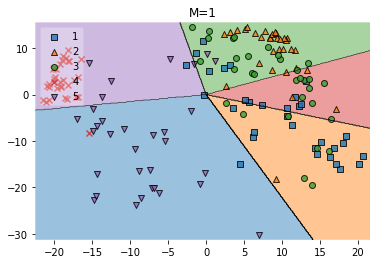

In [17]:
def PCA(features, n=2, n_eigVect=None, typ=1):
    mean = np.mean(features.T, axis=1)
    center = features - mean
    cov = np.cov(features, rowvar=0)
    eigenvalue, eigenvector = np.linalg.eig(np.mat(cov))
    sortEigValue = np.argsort(eigenvalue)  # sort eigenvalue
    topNvalue = sortEigValue[-1:-(n + 1):-1]  # select top n value
    if typ ==1 : # training data
        n_eigVect = eigenvector[:, topNvalue]  # select largest n eigenvector
    # recon = (C*n_eigVect.T) + M  # reconstruct to original data
    Trans = center * n_eigVect  # transform to low dim data (same as the return of sklearn fit_transform())
    # transform matrix to array
    Trans = np.asarray(Trans).real
    return Trans, n_eigVect, sortEigValue
    # print(Trans.shape)
model = newtonRaphson(2, 5)
X_train, n_eigVect, _ = PCA(X_train, n=2, typ=1)
X_test, _, _ = PCA(X_test, n=2, n_eigVect=n_eigVect, typ=2)
model.fit_byNR(X_train, y_train,X_test, y_test, epochs=1)
from mlxtend.plotting import plot_decision_regions

# Plotting decision regions
plot_decision_regions(X_train, change_y(y_train), clf=model, legend=2)
#plot_decision_regions(X_test, change_y(y_test), clf=model)
plt.title('M=1')
plt.show()
